In [2]:
import math

In [3]:
d_i = 0.01
d_o = 0.02
pi = math.pi

In [4]:
def get_rho(Tc):
    if Tc <= 422:
        rho = 2137.7 - 0.8487*Tc
    elif Tc > 422 and Tc < 462:
        rho = 21125 - 129.29*Tc+ 0.2885*(Tc**2) - 0.00021506*(Tc**3)
    else:
        rho = 2050.8 - 0.6240*Tc
        
    return rho

In [5]:
def get_Ac():
    Ac = (pi/4) * (d_o**2 - d_i**2) # Cross-sectional area
    
    return Ac

In [6]:
def get_m(Tc, Ac):
    # Get mass for a cross-sectional area of pipe, assuming unit length
    rho = get_rho(Tc)
    m = Ac * rho
    
    return m

In [7]:
def get_Cp(Tc):           
    if Tc <= 392:                  
        Cp = 996.458/1000
    elif Tc > 392 and Tc <= 431.2:
        Cp = ( 3.636e-7*math.exp(1.925/(Tc - 440.4)) ) + ( 0.002564*Tc )
    elif Tc>431.2 and Tc<718:
        Cp= 1.065 + ( 2.599/(Tc- 428) ) - ( 0.3092/((Tc - 428)**2) ) + ( 5.911e-9*((Tc - 428)**3) )
    elif Tc>=718:
        Cp = 1215.535/1000;
    Cp = Cp*1000
        
    return Cp

if t_avg[i]<=392:                  
            cp_t_avg[i]= 996.458/1000 ;
        elif t_avg[i]>392 and t_avg[i]<= 431.2 :
            cp_t_avg[i]= ((3.636e-7)*(math.exp(1.925/(t_avg[i]- 440.4)) ) )+ 0.002564*t_avg[i] ;
        elif t_avg[i]>431.2 and t_avg[i]<718:
            cp_t_avg[i]= 1.065+ ( 2.599/(t_avg[i]- 428) )-( 0.3092/((t_avg[i]- 428)**2) ) + (5.911e-9)*((t_avg[i]- 428)**3) ;
        elif t_avg[i]>=718:
            cp_t_avg[i]= 1215.535/1000;
        cp_t_avg[i]=cp_t_avg[i]*1000;   

In [8]:
def get_As():
    As = pi * d_i # Heat transfer surface area, assuming unit length
    
    return As

In [9]:
def get_dTc_dt(Tc_list, i, timestep):
    ######################
    # Formula (Centered difference for discrete differentiation):
    #
    #           Tc_(t+1) - Tc_(t-1)
    # dTc/dt = --------------------
    #              2 * timestep
    #
    ######################
    
    Tc_prev = Tc_list[i - 1][0]
    Tc_next = Tc_list[i + 1][0]
    
    dTc_dt = (Tc_next - Tc_prev) / (2*timestep)
    
    return dTc_dt

In [35]:
def get_h(df):
    ######################
    # Formula:
    #
    #     m * Cp * dTc/dt
    # h = ---------------
    #      As * (Tw - Tc)
    #
    ######################
    
    # This formula assumes it is given a dataframe (df) from a single dataset
    # e.g. the data from a single test run with Tw = 550 and Ti = 440.
    
    Tc_list = df[["Tc"]].to_numpy()
    time_list = df[["Time"]].to_numpy()
    timestep = time_list[1][0] - time_list[0][0]
    Tw = df[["Tw"]].to_numpy()[0][0]
    As = get_As()
    Ac = get_Ac()
    #print('As=',As,'Ac=',Ac,'Tw=',Tw,'timestep=',timestep)
    
    h = list()
    for i, Tc in enumerate(Tc_list):
        Tc = Tc[0]
        if i == 0 or i == len(Tc_list) - 1: # Cannot get centered diff derivative for Tc at first and last datapoints
            continue
        m = get_m(Tc, Ac)
        Cp = get_Cp(Tc)
        dTc_dt = get_dTc_dt(Tc_list, i, timestep)
        
        h_i = (m * Cp * dTc_dt) / (As * (Tw-Tc))
        
        #print('m=',m,'Cp=',Cp,'dTc_dt=',dTc_dt,'Tc=',Tc,'h=',h_i)
        
        h.append(h_i)
        
    return h

In [11]:
import os
import pandas as pd
import numpy as np
import glob

from stesml.data_tools import get_train_and_test_index
from stesml.data_tools import load_data
from stesml.data_tools import series_to_supervised
from stesml.data_tools import get_train_data
from stesml.data_tools import get_test_data

In [12]:
data_dir = "../data/Air_Models/"

scenario_index = pd.DataFrame({"filepath": glob.glob(os.path.join(data_dir, "IG_*_*.csv"))})
scenario_index

,filepath
0,../data/Air_Models/IG_500_390.csv
1,../data/Air_Models/IG_520_300.csv
2,../data/Air_Models/IG_530_300.csv
3,../data/Air_Models/IG_600_560.csv
4,../data/Air_Models/IG_600_400.csv
...,...
135,../data/Air_Models/IG_370_300.csv
136,../data/Air_Models/IG_600_550.csv
137,../data/Air_Models/IG_600_430.csv
138,../data/Air_Models/IG_550_340.csv


In [13]:
train_index, test_index = get_train_and_test_index(scenario_index)

test_df = load_data(scenario_index, test_index, is_recurrent_test_data=True)

In [36]:
h = get_h(test_df[0])

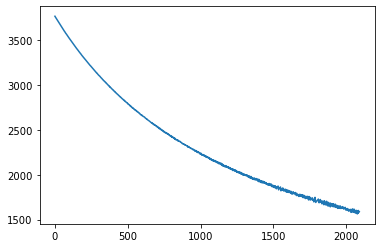

In [37]:
import matplotlib.pyplot as plt
window = 25
average_h = []
for ind in range(len(h) - window + 1):
    average_h.append(np.mean(h[ind:ind+window]))
    
plt.plot(average_h)